# Här testas de bästa vikterna från rapporten 
### https://doi.org/10.1038/s41598-019-38482-1

Modellen delas in i block och vi provar att träna om modellen med 1, 2, 3 eller 4 låsta block. Bäst resultat uppnås när endast första blocket är låst

#### Importera paket

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import re
from tqdm import tqdm

import tensorflow

from tensorflow.keras.layers import Convolution1D, GlobalAveragePooling1D, Activation, AveragePooling1D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Input, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split as split
from statistics import mean, stdev 
from sklearn import preprocessing 
from sklearn.model_selection import StratifiedKFold 
from sklearn import linear_model
from sklearn.decomposition import PCA, IncrementalPCA
from IPython.display import clear_output

val_split=0.2

#### Metoden returnerar den modell som användes i https://doi.org/10.1038/s41598-019-38482-1

In [2]:
def build_cnn_model(nr=0):
    model = Sequential()
    activation = 'relu'
    model.add(Convolution1D(2, 9, input_shape=(900,1), activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())

    model.add(Convolution1D(2, 7, activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())

    model.add(Convolution1D(4, 7, activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())

    model.add(Convolution1D(4, 5, activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())

    model.add(Convolution1D(8, 3, activation=activation))
    model.add(AveragePooling1D())
    model.add(BatchNormalization())

    model.add(Dropout(0.10))
    model.add(Convolution1D(2, 1))
    model.add(GlobalAveragePooling1D())

    model.add(Activation('softmax', name='loss'))

    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # print(model.summary())
    # print("CNN Model created. Model nr", nr)
    return model

#### Stödfunktion för att förbereda data samt träna och utvärdera en modell, utformad för automatisering av många tester


In [3]:
def train_model(model, X_train, X_test, y_train, y_test, size, nr):

    #Params
    epochs = 500
    batch_size = size
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-3, 
                                   patience=5, verbose=1, mode="auto",
                                   restore_best_weights=True)
    hist = model.fit(X_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     validation_data = (X_test, y_test),
                     callbacks=[early_stopping],
                     shuffle = True,
                     verbose=1)
    clear_output(wait=True)
    print("training done, model evaluation:")
    stats = model.evaluate(X_test, y_test)
    
    return hist, stats

#### Dataimport och förberedelse

In [4]:
covid_and_healthy_spectra = np.array(pd.read_csv('./covid19/covid_and_healthy_spectra.csv'))
size_1st_set = covid_and_healthy_spectra.shape

suspected_spectra = np.array(pd.read_csv('./covid19/suspected_spectra.csv'))
size_2nd_set = suspected_spectra.shape

y = np.zeros([size_1st_set[0],2])
y_bin = np.zeros([size_1st_set[0],1])

for i in range(size_1st_set[0]):
  
    if covid_and_healthy_spectra[i,-1:] == "SARS-CoV-2":
        y[i] = np.array([1,0])
        y_bin[i] = np.array([1])
        
    if covid_and_healthy_spectra[i,-1:] == "Healthy":
        y[i] = np.array([0,1])
        y_bin[i] = np.array([1])

labels = tensorflow.keras.utils.to_categorical(y)
data = covid_and_healthy_spectra[:,:-1].reshape(size_1st_set[0], 900)

#### Stödfunktion för att stänga av träningen för ett antal lager, 3,6,9 eller 12 för att stänga av 1, 2, 3 eller 4 block

In [5]:
def fix_layers(model, blocks):
    layer_nr=0
    for layer in model.layers:
        if layer_nr < blocks: 
            layer.trainable = False
        layer_nr+=1
    return model

#### Funktion för automatiserade tester

In [6]:
def fix_block_weights_test(batch_size, data, y, y_bin, tests, blocks):
    """
    Blocks motsvarar hur stor % av de förtränade vikterna som ska hållas statiska under träningen,
    alltså hur många lager som ska ändras till layer.trainable=False
    """
    hist_list = []
    loss = []
    acc = []
    batch_size = batch_size

    for trial in range(tests):
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345) 
 
        scaler = preprocessing.MinMaxScaler() 
        x_scaled = scaler.fit_transform(data)

        nr = 1

        for train_index, test_index in skf.split(data, y_bin): 
            X_train, X_test = x_scaled[train_index], x_scaled[test_index] 
            y_train, y_test = y[train_index], y[test_index]
            X_train = X_train.reshape(len(X_train),900,1)
            X_test = X_test.reshape(len(X_test),900,1)
            
            layer_nr = 0
            model = build_cnn_model()
            model.load_weights('.//best_weights//highest_val_acc_weights_epoch199-train_loss0.026_.h5', 
                                by_name=True, skip_mismatch=True)
            model = fix_layers(model, blocks)    
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            
            hist, evaluation = train_model(model, 
                                           X_train, X_test, 
                                           y_train, y_test,
                                          size, nr)

            loss.append(evaluation[0])
            acc.append(evaluation[1])
            hist_list.append(hist)
            nr += 1
    
    return {'Training History':hist_list, 'Evaluation Accuracy':acc, 'Evaluation Loss':loss}

#### Här hålls 17% av nätverket statiskt

In [7]:
test0 = fix_block_weights_test(batch_size=4, data, y=y, y_bin=y_bin, tests=10, blocks=3)

training done, model evaluation:
30/30 [==============================] - 0s 133us/sample - loss: 0.2852 - accuracy: 0.9333


In [8]:
avg_loss_test0 = np.mean(test0['Evaluation Loss'])
avg_acc_test0 = np.mean(test0['Evaluation Accuracy'])

print('Average loss when fixing one block was', avg_loss_test0)
print('Average accuracy when fixing one block was', avg_acc_test0)

Average loss when fixing one block was 0.5687037293612957
Average accuracy when fixing one block was 0.630914


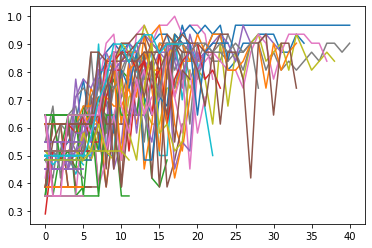

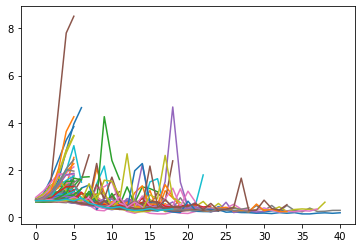

In [9]:
fig = plt.figure(figsize=(6,4))
for hist in test0['Training History']:
    plt.plot(hist.history['val_accuracy'])
plt.show()

fig = plt.figure(figsize=(6,4))
for hist in test0['Training History']:
    plt.plot(hist.history['val_loss'])
plt.show()

#### Här hålls 33% av nätverket statiskt

In [10]:
test1 = fix_block_weights_test(4, data, y, y_bin, 10, 6)

training done, model evaluation:
30/30 [==============================] - 0s 100us/sample - loss: 0.5307 - accuracy: 0.7667


In [11]:
avg_loss_test1 = np.mean(test1['Evaluation Loss'])
avg_acc_test1 = np.mean(test1['Evaluation Accuracy'])

print('Average loss when fixing two blocks was', avg_loss_test1)
print('Average accuracy when fixing two blocks was', avg_acc_test1)

Average loss when fixing two blocks was 0.5804744002223015
Average accuracy when fixing two blocks was 0.6385161


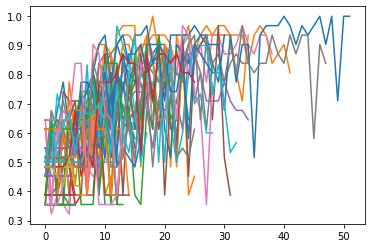

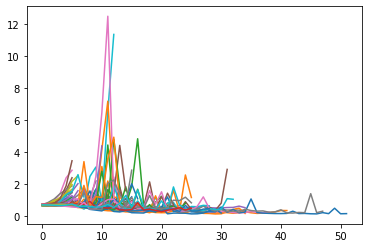

In [12]:
fig = plt.figure(figsize=(6,4))
for hist in test1['Training History']:
    plt.plot(hist.history['val_accuracy'])
plt.show()

fig = plt.figure(figsize=(6,4))
for hist in test1['Training History']:
    plt.plot(hist.history['val_loss'])
plt.show()

#### Här hålls 50% av nätverket statiskt

In [13]:
test2 = fix_block_weights_test(4, data, y, y_bin, 10, 9)

training done, model evaluation:
30/30 [==============================] - 0s 133us/sample - loss: 0.6596 - accuracy: 0.6000


In [14]:
avg_loss_test2 = np.mean(test2['Evaluation Loss'])
avg_acc_test2 = np.mean(test2['Evaluation Accuracy'])

print('Average loss when fixing three blocks was', avg_loss_test2)
print('Average accuracy when fixing three blocks was', avg_acc_test2)

Average loss when fixing three blocks was 0.6271926125884056
Average accuracy when fixing three blocks was 0.60404295


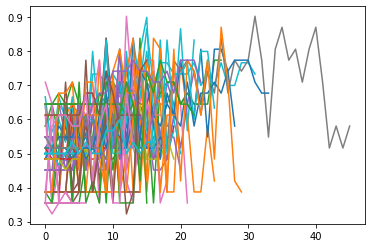

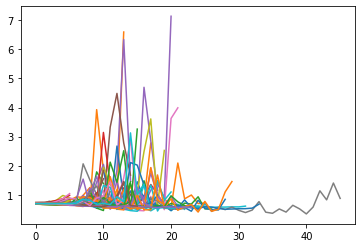

In [15]:
fig = plt.figure(figsize=(6,4))
for hist in test2['Training History']:
    plt.plot(hist.history['val_accuracy'])
plt.show()

fig = plt.figure(figsize=(6,4))
for hist in test2['Training History']:
    plt.plot(hist.history['val_loss'])
plt.show()

#### Här hålls 67% av nätverket statiskt

In [16]:
test3 = fix_block_weights_test(4, data, y, y_bin, 10, 12)

training done, model evaluation:
30/30 [==============================] - 0s 133us/sample - loss: 0.6933 - accuracy: 0.5000


In [17]:
avg_loss_test3 = np.mean(test3['Evaluation Loss'])
avg_acc_test3 = np.mean(test3['Evaluation Accuracy'])

print('Average loss when fixing four blocks was', avg_loss_test3)
print('Average accuracy when fixing four blocks was', avg_acc_test3)

Average loss when fixing four blocks was 0.6648539406061172
Average accuracy when fixing four blocks was 0.5707311


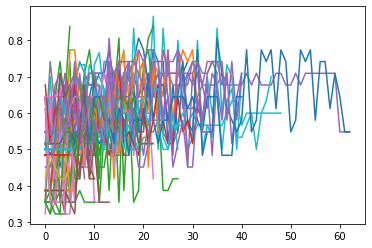

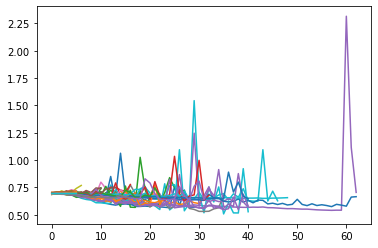

In [18]:
fig = plt.figure(figsize=(6,4))
for hist in test3['Training History']:
    plt.plot(hist.history['val_accuracy'])
plt.show()

fig = plt.figure(figsize=(6,4))
for hist in test3['Training History']:
    plt.plot(hist.history['val_loss'])
plt.show()